<a href="https://colab.research.google.com/github/hillsonghimire/EO-training-resources/blob/main/Topographic_Wetness_Index_(TWI).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ==========================================
#  Title:  Surface Water Dynamics in GEE. Case study of Lake Gowd-e-Zareh, Afghanistan
#  Author: hillson ghimire
#  Date:   Dec 2024
# ==========================================

Access presentation: [Google Slides](https://docs.google.com/presentation/d/1TVmcT6szZi6NEb3PQTYNHq9AuLFfAEu29pfhfF_c3ME/edit?usp=sharing)

## Landsat selection guide



*   1984 - 1999: Landsat 5   **- 1985, 1990, 1995** (multispectral sensor)
*   1999 - 2013: Landsat 7   **- 2000, 2005, 2010** (Enhanced Thematic Mapper Plus -  ETM+)
*   2013 - 2021: Landsat 8   **- 2015, 2020, 2021** (Operational Land Imager (OLI)/ Thermal Infrared sensor (TIRS))
*   2021 -  .now: Landsat 9 **- beyond 2021** (OLI/TIRS)

** Landsat 6 Failed to reach orbit
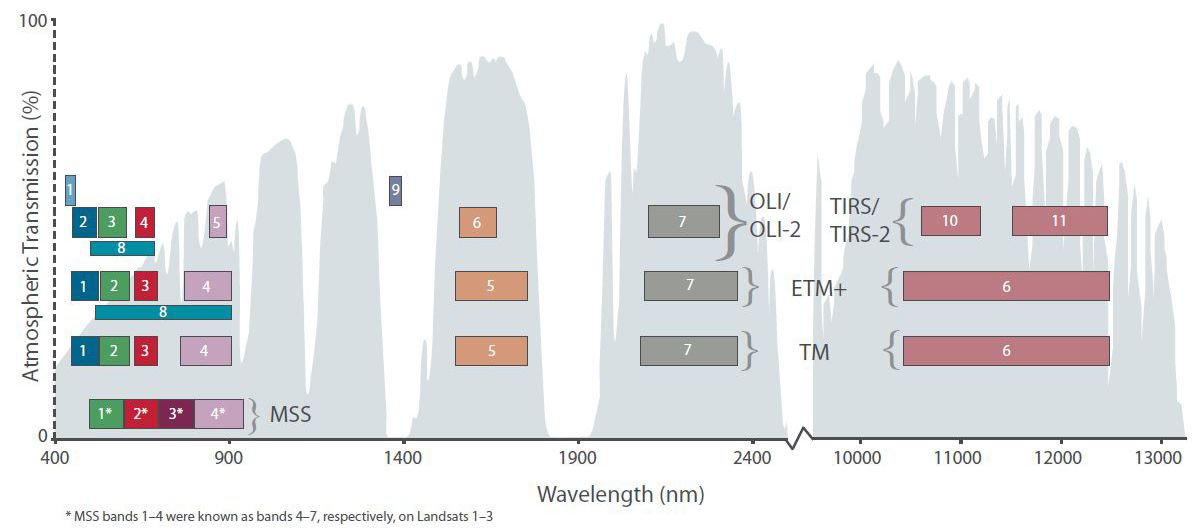










---

### Rough Outline

1. Surface Water Mapping
2. Binary Map (gap filled using filtering technique to fill gap in water body)
3. Temporal data (1985, 2023, 5 years interval)- mean composite landsat
4. Map overlay, different colors for different years
5. percentage calulation of area and change between consecutive time frames (each temporal data)
6. plot the trend of area changes.

# **Case Study of Lake Gowd-e-Zareh**

In [ ]:
print("Drag the vertical arrow in the image, left <--> right")


from IPython.display import IFrame
IFrame("https://cdn.knightlab.com/libs/juxtapose/latest/embed/index.html?uid=800e83b0-94cc-11ee-9ddd-3f41531135b6", 800,800)

#https://cdn.knightlab.com/libs/juxtapose/latest/embed/index.html?uid=800e83b0-94cc-11ee-9ddd-3f41531135b6

Drag the vertical arrow in the image, left <--> right


### Import necessary library and authorize the notebook to access Earth Engine

In [ ]:
# !pip install geemap
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


import geemap
import ipywidgets as widgets

import ee
ee.Authenticate()

True

In [ ]:
# ee.Initialize()
# Follow seteps in the URL: https://docs.google.com/presentation/d/1dUz_bUfV57OIuXEAoMxbvXRZeXbqB7bd-_RhIjCcE90/edit?usp=sharing

ee.Initialize(project='gee-ait')
# L7Col = ee.ImageCollection("LANDSAT/LE07/C02/T1_L2")

### Setting up map visualization parameter

LANDSAT DN VALUES RANGES FROM : 0 to 65536

In [ ]:
# Feature scaling is a data preprocessing technique used to transform the values of features or variables in a dataset to a similar scale.
# The purpose is to ensure that all features contribute equally to the model and to avoid the domination of features with larger values.

# Visualization parameter for Landsat images (used in later part)
vis_param_L457 = {'min': 0, 'max': 30000, 'bands': ['SR_B3', 'SR_B2', 'SR_B1']} # for landsat raw image visualization
sc_vis_param_L457 = {'min':0, 'max':0.3, 'bands': ['SR_B3', 'SR_B2', 'SR_B1']} # for scaled landsat image visualization

# More information on Landsat Colletion 2 Surface Reflectance data scaling:
# https://www.usgs.gov/faqs/how-do-i-use-a-scale-factor-landsat-level-2-science-products#:~:text=Landsat%20Collection%202%20surface%20temperature,the%20scale%20factor%20is%20applied.

vis_param_L8 = {'min': 0, 'max': 30000, 'bands': ['SR_B4', 'SR_B3', 'SR_B2']} # for landsat raw image visualization
sc_vis_param_L8 = {'min':0, 'max':0.3, 'bands': ['SR_B4', 'SR_B3', 'SR_B2']} # for scaled landsat image visualization

# Map visualisation parameters
zoom = 8
width="40%"
center = [29.9617498,61.7604367]

# Select Area of Interest (AOI) using 'Draw a Rectangle' tool, the first drawn shape will become AOI
print("Select AOI using 'Draw a Rectangle' tool")
Map = geemap.Map(center = center, zoom = zoom,  width=width)
feature = Map.draw_features
Map

In [ ]:
# Print the information on AOI drawn above
# Note it will give error, if no AOI is selected in previous step
Map.draw_control.data

# Learn more about draw_control in geemap library
# https://geemap.org/notebooks/138_draw_control/

[{'type': 'Feature',
  'properties': {'style': {'stroke': True,
    'color': '#3388ff',
    'weight': 4,
    'opacity': 0.5,
    'fill': True,
    'fillColor': None,
    'fillOpacity': 0.2,
    'clickable': True}},
  'geometry': {'type': 'Polygon',
   'coordinates': [[[61.243453, 29.617612],
     [61.243453, 30.241246],
     [62.649906, 30.241246],
     [62.649906, 29.617612],
     [61.243453, 29.617612]]]}}]

#### The *draw_control.data* contains detaied information on *type*, *properties*, and *geometry(including geometry type and coordinates)*

We'll get the coordinates data and convert to earth engine geometry type (ee.Geometry.Polygon)

**ee.Geometry.Polygon(coords, proj, geodesic, maxError)**

*   coords: type = List	: A list of rings defining the boundaries of the polygon

*   proj : optional : projection of this geometry

*   geodesic: Boolean, optional : If false, edges are straight in the projection. If true, edges are curved to follow the shortest path on the surface of the Earth
*   maxError:  ErrorMargin, optional






In [ ]:
features = []
for element in (Map.draw_control.data):
  new_dict = {key: value for key, value in element.items() if key == 'geometry'}
  print("new_dict:", new_dict)
  features.append(new_dict)

# features[0]
# features[0]['geometry']['coordinates']

# EE Documentation: https://developers.google.com/earth-engine/apidocs/ee-geometry-polygon
# False in geodesic parameter, means line will be drawn straight instead of curve(to match earth surface)

aoi = ee.Geometry.Polygon(features[0]['geometry']['coordinates'], None, False)
display(aoi)

### Cloud Masking

Cloud and cloud shadow creates challenges in remote sensing based optical image analysis, and interpretation. Clouds and cloud shadows decrease the accuracy of remote sensing application as they obscure the land surface and the brightening effect of clouds and darkening effect of cloud shadows influences the reflectance capability of target object.

*Cloud masking* solves the problem of cloud shadow. It is the process of identifying clouds from satellite images and eliminating them so as to obtain a cloud-free image. Cloud masking ensures that the pixels in the image are *transparent* and excluded from further analysis.

In [ ]:
##  Cloud masking algorithms for Landsat 4, 5, 7 surface reflectance
def maskL457sr(image):
  qaMask = image.select('QA_PIXEL').bitwiseAnd(ee.Number.parse('11111', 2)).eq(0).rename("QA_MASK")
  saturationMask = image.select('QA_RADSAT').eq(0)    # The QA_RADSAT band indicates which sensor band(s) are saturated.

  # Apply the scaling factors to the appropriate bands.
  opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
  thermalBands = image.select('ST_B6').multiply(0.00341802).add(149.0)

  # Replace the original bands with the scaled ones and apply the masks.
  return image.addBands(opticalBands, None, True) \
              .addBands(thermalBands, None, True)  \
              .updateMask(qaMask) \
              .updateMask(saturationMask)


#  Cloud masking algorithms for Landsat 8 surface reflectance
def maskL8sr(image):
  qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111',2)).eq(0).rename("QA_MASK")
  saturationMask = image.select('QA_RADSAT').eq(0)

  # Apply the scaling factors to the appropriate bands.
  opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
  thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)

  # Replace the original bands with the scaled ones and apply the masks.
  return image.addBands(opticalBands, None, True) \
              .addBands(thermalBands, None, True)  \
              .updateMask(qaMask) \
              .updateMask(saturationMask)

**More on ee.Image.addBands() function:**

Image.addBands(srcImg, names, overwrite), **names=None** means that the 'srcImg' band names will be copied; **overwrite=True**, overrides band with same names in 'dstImg'

In [ ]:
## TEST
L5Col_test = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2') \
                .filterDate('1995-01-01', '1995-02-20') \
                .filterBounds(aoi) \
                .filter(ee.Filter.gt('CLOUD_COVER', 10)) \
                .map(algorithm=maskL457sr) \
                .median()

Map = geemap.Map(center = center, zoom = zoom, width = width)
Map.addLayer(L5Col_test, sc_vis_param_L457, name="TEST")
Map

#### Exercise: Try changing the start date from 1995 to 1993, what do you notice?

In [ ]:
# Write Code Here

#### Exercise: Select and visualize the - NIR band from the image


**Hint:**

1. Use **select()** function.

2. More info on Landsat 8 Bands: https://www.esri.com/arcgis-blog/products/product/imagery/band-combinations-for-landsat-8/

3. Display list of bands name: display(image.bandNames())

In [ ]:
# Uncomment the code below and make changes to it as required
# nir_test = L5Col_test.<your_code_here>


# Visualize NIR Band
Map = geemap.Map(center = center, zoom = zoom, width = width)
Map.addLayer(nir_test, name="NIR")
Map

During scaling, the scaling factors are used in Surface Reflectance products as recommended by the USGS.

https://www.usgs.gov/faqs/why-are-fill-values-and-scaling-factors-landsat-collection-2-level-2-products-different-those

### Water Body Extraction

Water body extraction methods include water body extraction algorithms based on band combination (single-band threshold method, multiband spectral relation method, water index method, and threshold method) and machine learning algorithm (support vector machines, random forest, deep learning).

The water body index can quickly obtain the distribution range of the water body through simple band calculation and threshold processing. For example, Mefeeters et al. proposed the normalized difference vegetation index (NDVI) index, which suppresses vegetation and highlights water information but the suppression effect in buildings was not good. Xu proposed that the modified normalized difference water index (MNDWI) can reduce the interference of soil and buildings, but it is not effective in distinguishing water bodies from vegetation.

This study uses a **combination of MNDWI, normalized difference vegetation index (NDVI), and enhanced vegetation index (EVI)**, which can eliminate land noise and decrease wetlands mixed with water bodies and vegetation to improve the accuracy of the water body index.


**Reference Paper:**


```
https://www.degruyter.com/document/doi/10.1515/geo-2020-0305/html
```

If a pixel meets the given criteria, than it will be classified as a water body
```
EVI < 0.1 and (MNDWI > EVI or MNDWI > NDVI)
```



Formula for each indices are:
```
MNDWI = (Green – SWIR) / (Green + SWIR)

NDVI = (NIR - R) / (NIR + R)

EVI = 2.5 \* ((NIR – RED) / (NIR + 6 \* RED – 7.5 * BLUE + 1))

```

More information on satellite derived indices: https://github.com/awesome-spectral-indices/awesome-spectral-indices

#### Water Masking Algorithm

In [ ]:
def MaskWaterFunc(image, blueBand, greenBand, redBand,  nirBand, swirBand):  # image is median aggregiated single image from the collection, not data of type ImageCollection!!!
  MNDWI = image.expression(
      '((greenBand - swirBand) / (greenBand + swirBand))',
        {
          'greenBand': image.select(greenBand),
          'swirBand': image.select(swirBand),
        },
      ).rename("MNDWI")

  NDVI = image.expression(
      '((nirBand - redBand) / (nirBand + redBand))',
        {
          'nirBand': image.select(nirBand),
          'redBand': image.select(redBand),
        },
      ).rename("NDVI")

  EVI = image.expression(
      '2.5 * ((nirBand - redBand) / (nirBand + 6 * redBand - 7.5 * blueBand + 1))',
        {
          'nirBand': image.select(nirBand),
          'redBand': image.select(redBand),
          'blueBand': image.select(blueBand),
        },
      ).rename("EVI")

  # Water Body Criteria: EVI < 0.1 and (MNDWI > EVI or MNDWI > NDVI)
  waterBody = EVI.lt(0.1).And(MNDWI.gt(EVI).Or(MNDWI.gt(NDVI)))
  return waterBody.rename("WATER")

#### Initializing suitable Satellite Data for our AOI

In [ ]:
# Load ImageCollection from Earth Engine using its asset ID
# For Example, landsat collection on earth engine: https://developers.google.com/earth-engine/datasets/catalog/landsat

L5Col = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2').filterBounds(aoi).filter(ee.Filter.lt('CLOUD_COVER', 10)) # Landsat 5
L7Col = ee.ImageCollection("LANDSAT/LE07/C02/T1_L2").filterBounds(aoi).filter(ee.Filter.lt('CLOUD_COVER', 10)) # Landsat 7
L8Col = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2").filterBounds(aoi).filter(ee.Filter.lt('CLOUD_COVER', 10)) # Landsat 8

#### Pre-processing steps

In [ ]:
waterMask = {}

for year in range(1985, 2025, 5):

  # Years using Landsat-5 image collection
  if year in [1985, 1990, 1995]:
    imgCollection = L5Col.filterDate(f'{int(year)-1}-01-01', f'{int(year)+1}-12-31')    # filter collection by date
    imgCloudMask = imgCollection.map(algorithm=maskL457sr)                              # run cloud masking and scale the pixel values
    imgAgg = imgCloudMask.median().clip(aoi)                                            # aggregate the image and clip over AOI

    display(imgAgg)                                                                     # diplay "imgAgg" image properties for each year's image
    key = f'waterMask_{year}'                                                           # initialize key

    # Apply Extract Water Mask Algorithm to the images.
    waterBody = MaskWaterFunc(imgAgg, blueBand = 'SR_B1', greenBand = 'SR_B2', redBand = 'SR_B3', nirBand = 'SR_B4', swirBand = 'SR_B5')  # Run MaskWaterFunc algorithm to mask water bodies
    waterMask[key]=[imgAgg, waterBody]                                                  # save satellite image, and water body mask into dictionary

  # Years using Landsat-7 image collection
  if year in [2000, 2005, 2010]:
    imgCollection = L7Col.filterDate(f'{int(year)-1}-01-01', f'{int(year)+1}-12-31')
    imgCloudMask = imgCollection.map(algorithm=maskL457sr)
    imgAgg = imgCloudMask.median().clip(aoi)
    key = f'waterMask_{year}'
    display(imgAgg)
    waterMask[key]=[imgAgg, MaskWaterFunc(imgAgg, blueBand = 'SR_B1', greenBand = 'SR_B2', redBand = 'SR_B3', nirBand = 'SR_B4', swirBand = 'SR_B5')]

  # Years using Landsat-8 image collection
  if year in [2015, 2020]:
    imgCollection = L8Col.filterDate(f'{int(year)-1}-01-01', f'{int(year)+1}-12-31')
    imgCloudMask = imgCollection.map(algorithm=maskL8sr)
    imgAgg = imgCloudMask.median().clip(aoi)
    key = f'waterMask_{year}'
    display(imgAgg)
    waterMask[key]=[imgAgg, MaskWaterFunc(imgAgg, blueBand = 'SR_B2', greenBand = 'SR_B3', redBand = 'SR_B4', nirBand = 'SR_B5', swirBand = 'SR_B6')]

#### Test code steps here

In [ ]:
def MaskWaterFunc_TEST(image, blueBand, greenBand, redBand,  nirBand, swirBand):  # image is median aggregiated single image from the collection, not data of type ImageCollection!!!
  MNDWI = image.expression(
      '((greenBand - swirBand) / (greenBand + swirBand))',
        {
          'greenBand': image.select(greenBand),
          'swirBand': image.select(swirBand),
        },
      ).rename("MNDWI")

  NDVI = image.expression(
      '((nirBand - redBand) / (nirBand + redBand))',
        {
          'nirBand': image.select(nirBand),
          'redBand': image.select(redBand),
        },
      ).rename("NDVI")

  EVI = image.expression(
      '2.5 * ((nirBand - redBand) / (nirBand + 6 * redBand - 7.5 * blueBand + 1))',
        {
          'nirBand': image.select(nirBand),
          'redBand': image.select(redBand),
          'blueBand': image.select(blueBand),
        },
      ).rename("EVI")

  # Water Body Criteria: EVI < 0.1 and (MNDWI > EVI or MNDWI > NDVI)
  waterBody = EVI.lt(0.1).And(MNDWI.gt(EVI).Or(MNDWI.gt(NDVI)))

  # Return all data for testing purpose
  return waterBody.rename("WATER"), MNDWI.rename("MNDWI"), NDVI.rename("NDVI"), EVI.rename("EVI")


In [ ]:
L5Col_test = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2') \
                .filterDate('1995-01-01', '1995-02-20') \
                .filterBounds(aoi) \
                .filter(ee.Filter.gt('CLOUD_COVER', 10)) \
                .map(algorithm=maskL457sr) \
                .median()  \
                .clip(aoi)

# display(L5Col_test)

# Apply Extract Water Mask Algorithm to the images.
waterBody, mndwi, ndvi, evi = MaskWaterFunc_TEST(L5Col_test, blueBand = 'SR_B1', greenBand = 'SR_B2', redBand = 'SR_B3', nirBand = 'SR_B4', swirBand = 'SR_B5')  # Run MaskWaterFunc algorithm to mask water bodies


# Visualize all Layers
Map = geemap.Map(center = center, zoom = zoom, width = width)

Map.addLayer(L5Col_test, sc_vis_param_L457, name="L8 data")
Map.addLayer(waterBody, name="Water Body")
Map.addLayer(ndvi,{'min': -1, 'max': 1, 'palette': 'Greens'}, name="NDVI")
Map.addLayer(mndwi, {'min': -1, 'max': 1, 'palette': 'Blues'}, name="MNDWI")
Map.addLayer(evi, {'min': -1, 'max': 1, 'palette': 'turbo'}, name="EVI")

Map

**Layers can be toggles as in image:**
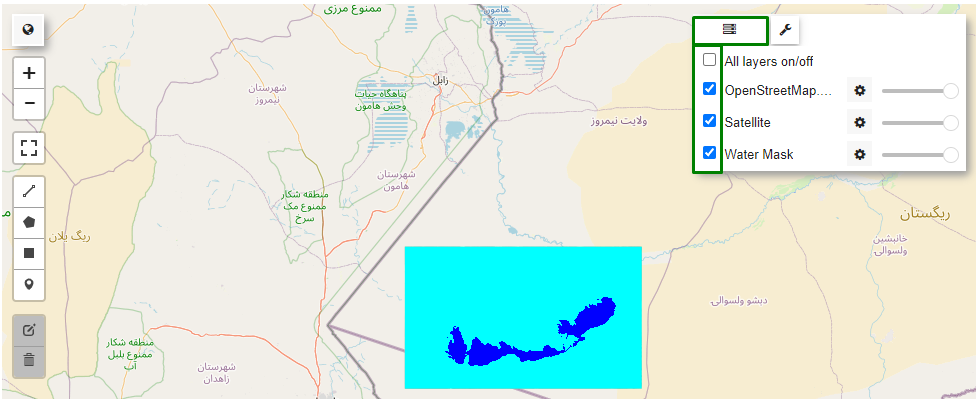

#### Visualization

In [ ]:
waterMask

# Contains two images:
# 1. Satellite Data for Year
# 2. Water Mask for the same year

In [ ]:
Map = geemap.Map(center = center, zoom = zoom, width = width)
Map.addLayer(waterMask['waterMask_1990'][0], sc_vis_param_L457, name="Satellite")
Map.addLayer(waterMask['waterMask_1990'][1],{'palette': ['00FFFF', '0000FF']}, name="Water Mask")
Map

# waterMask

In [ ]:
# waterMask['waterMask_1990'][1]

Map = geemap.Map(center = center, zoom = zoom, width = width)
Map.addLayer(waterMask['waterMask_2010'][0], sc_vis_param_L457, name="Satellite")
Map.addLayer(waterMask['waterMask_2010'][1],{'palette': ['00FFFF', '0000FF']}, name="Water Mask")
Map

In [ ]:
# Uncomment to know more about the layers
waterMask['waterMask_1990'][1]      # water mask (binary layer, 0 - no water, 1 - water)
waterMask['waterMask_1990'][0]      # satellite image (cloud free composite)

### Vectorize the masked raster layer

This will take a while!

In [ ]:
# Background for below code:

print(list(waterMask.keys())) # display the list of all the keys

**waterMask[item][1] # each item has two data:**

0 (satellilte image)

1 (water mask), above code selects water mask

**reduceNeighborhood(ee.Reducer.mode(), ee.Kernel.circle(5))**

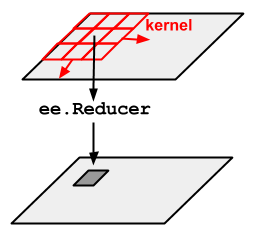


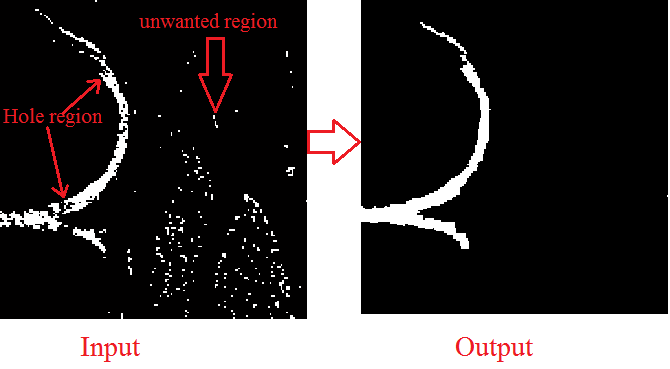

In [ ]:
# function to calculate area of geometry in sq km. and add property to ee feature.

def add_area_property(feature):
    area = feature.geometry().area(maxError=1).divide(ee.Number(1000000))
    # The maxError=1 is setting the maximum allowable error for the area calculation to be 1 meter.
    return feature.set('area', area)

# Looping through each water mask raster to convert rasters to vector
watermaskVector = {}
for item in list(waterMask.keys()):
  # https://gis.stackexchange.com/a/413138/126926
  wmReduced = waterMask[item][1].reduceNeighborhood(ee.Reducer.mode(), ee.Kernel.circle(5))    # filter operation, to remove isolated pixels

  # Raster to Vector operation
  vectors = ee.Image(wmReduced).selfMask().reduceToVectors(
    geometry=aoi,
    scale= 30,
    eightConnected= True,
    maxPixels= 1e10,
    tileScale= 16
  )

  # calculate area of each vectors
  vectorAreaProp = vectors.map(add_area_property)           # add 'area' property by calculating from geometry
  vectorWaterMask = (vectorAreaProp.sort('area', False))    # sort the features within featureCollection by 'area' property in descending order
  vectorWaterMask = vectorWaterMask.limit(20)               # only top 'n' largest water bodies will be selected
  display(vectorWaterMask)

  # Add to the dictionary
  watermaskVector[item] = vectorWaterMask

In [ ]:
# Display the extracted vector water body layer

MapFinal = geemap.Map(center = center, zoom = 10, height="800px", width = "50%")

for layer in watermaskVector:
  MapFinal.addLayer(waterMask[str(layer)][0], sc_vis_param_L457, name=layer.split("_")[1]+"_Landsat")   # satellite image
  MapFinal.addLayer(watermaskVector[layer], name=layer)                             # vector water mask
MapFinal

In [ ]:
# Demo: Traversing through featureCollection -> feature -> properties

# Take feature collection item
featureCol = watermaskVector['waterMask_2020']
display(featureCol)

# Display feature
feature = featureCol.first()
display(feature)

# Display feature as dictionary
dictx = feature.toDictionary()    # type: <class 'ee.dictionary.Dictionary'>
display(dictx)

# Display area property
  # dictx.get('area')             # possible way, but not preferred
  # .getInfo() changes the ee.dictionary.Dictionary asset to python dictionary which we can manipulate in our program
dictx.getInfo()['area']

In [ ]:
# coordinates_list = featureCol.aggregate_array('area').getInfo()
# featureCol.reduceColumns(ee.Reducer.sum(),['area']).get('sum')

### Plot measurement of area occupied by water over each Semi‐decadal period

In [ ]:
waterArea = []

keys = list(watermaskVector.keys())
print(keys)
for item in keys:
  areaSum = watermaskVector[item].reduceColumns(ee.Reducer.sum(),['area']).get('sum').getInfo()
  waterArea.append(areaSum)

# .reduceColumns(ee.Reducer.sum(),['area']), applies ee.Reducer.sum() to add all 'area' field, and appends a 'sum' attribute in the dataset.
#  We can then retrieve this 'sum' value using .getInfo()

In [ ]:
print(waterArea)

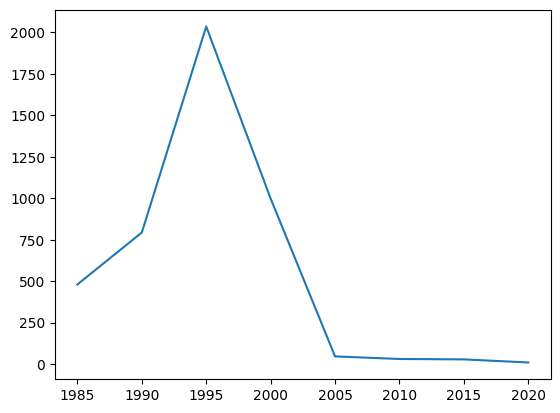

In [ ]:
time_frame = list(range(1985, 2025, 5))
plt.plot(time_frame, waterArea)

Additional Material: [Colab Notebook](https://colab.research.google.com/drive/1goNHOsdH_Dfjgqx8saL8fon7FXej2kE-?usp=sharing)

**References:**



```
https://www.degruyter.com/document/doi/10.1515/geo-2020-0305/html
https://spatialthoughts.com/2023/01/18/automated-coastline-extraction-gee/
```

